In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

sns.color_palette("icefire", as_cmap=True)
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv('tweets.csv')
df.head()

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,NaN
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author_id      3000 non-null   object 
 1   created_at     3000 non-null   object 
 2   id             3000 non-null   object 
 3   lang           3000 non-null   object 
 4   retweet_count  3000 non-null   int64  
 5   text           3000 non-null   object 
 6   sinal          1372 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 164.2+ KB


In [8]:
df = df.drop(columns=['author_id', 'created_at', 'id', 'lang', 'retweet_count'])
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,Periga o Argenta chamar o Simon pra responder ...,NaN
2,RT @WinstonLing Segue o link para assistirem o...,1.0
3,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [9]:
df.isnull().sum()

text        0
sinal    1628
dtype: int64

In [10]:
df = df.dropna()
df.isnull().sum()

text     0
sinal    0
dtype: int64

In [11]:
df.duplicated().sum()

253

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
df.shape

(1119, 2)

In [15]:
df['sinal'] = df['sinal'].astype('int64')
df.head(10)

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1
2,RT @WinstonLing Segue o link para assistirem o...,1
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
5,@EduardoLeite_ 🤡,0
6,Nós já governamos o Rio Grande Sul com @olivio...,0
7,Onyx Caixa 2 confesso não pode falar em corrup...,0
8,@onyxlorenzoni Essa gente de bem é mesma que é...,0
9,RT @LeonelRadde @EdegarPretto demolindo o Onyx...,0
10,RT @JulianaBrizola Oi O PDT não coloca educaçã...,0
11,RT @O_Marcoss Chegou até suar o implante novo ...,0


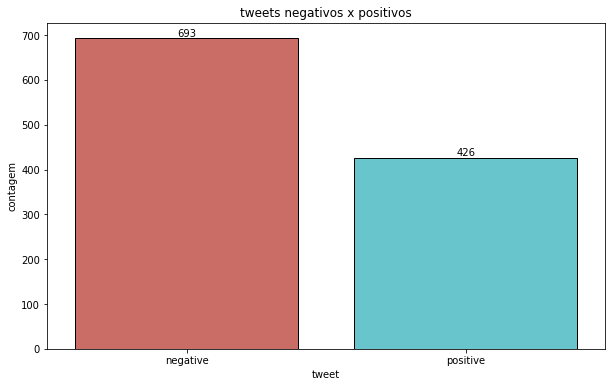

In [83]:
df2 = df.groupby('sinal').count()
df2 = df2.reset_index()
df2['sinal'] = df2['sinal'].apply(lambda x: 'negative' if x==0 else 'positive')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df2, x='sinal', y='text', palette='hls', edgecolor='black')
ax.set_title('tweets negativos x positivos')
ax.set_ylabel('contagem')
ax.set_xlabel('tweet')

for i in ax.containers:
    ax.bar_label(i, size=10)

plt.show()

## Upsampling dos tweets positivos

In [96]:
def tokenize(text):
    # make all text lowercase 
    text = text.lower()

    # remove all type of punctuations 
    text = re.sub(f'[^a-z0-9]',' ', text)

    # tokenize the text
    tokens = word_tokenize(text)

    # lemmatize the text
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    # remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words('portuguese')]
    
    return tokens

def plot_results(y_test, y_pred):
    # matrix de confusão
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cmap="icefire")
    plt.show()
    
    # métricas da classificação 
    target_names = ['negative', 'positive']
    print(classification_report(y_test, y_pred, target_names = target_names))

In [92]:
df

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1
2,RT @WinstonLing Segue o link para assistirem o...,1
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0
5,@EduardoLeite_ 🤡,0
6,Nós já governamos o Rio Grande Sul com @olivio...,0
...,...,...
2918,@onyxlorenzoni Carai chevrolet tá puto,0
2919,Agora é pau cu dos liberaloides fogo nos fasci...,0
2922,@onyxlorenzoni Ele é bom historiador pena que...,0
2924,#DebateNaBandRS lá vem mesmas lenga-lengas de ...,0


In [102]:
df.iloc[0, 0]

'RT @EdegarPretto O meu candidato vice-governador é o @PedroRuasPsol fundador trabalhismo e defensor da escola integral de Leonel Bri…'

In [95]:
X = df['text']
y = df['sinal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

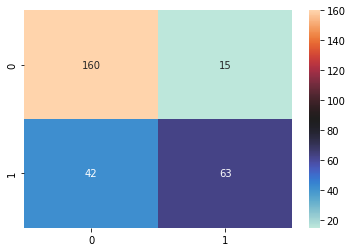

              precision    recall  f1-score   support

    negative       0.79      0.91      0.85       175
    positive       0.81      0.60      0.69       105

    accuracy                           0.80       280
   macro avg       0.80      0.76      0.77       280
weighted avg       0.80      0.80      0.79       280



In [99]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(300, 200, 100, 50), max_iter=500, activation='tanh', solver='adam'))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
plot_results(y_test, y_pred)